## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
random.seed(0)

#### Funciones a usar

In [2]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_crema_d(path):
    return path[119:122]


#Obtiene el codigo en el nombre del archivo para el dataset SAVEE
def get_code_savee(path):
    return path[108]


#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [3]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
    emotions_code = ["NEU", "FEA","ANG"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)
    files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
    emotions_code_s = ["a", "f","n"]
    datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 
    examples = []
    files_filters = dict()
    files_filters["NEU"] = 0
    files_filters["FEA"] = 0
    files_filters["ANG"] = 0
    files_filters["a"] = 0
    files_filters["f"] = 0
    files_filters["n"] = 0
    examples = get_features(datas_files, get_code_crema_d, files_filters)
    examples_s = get_features(datas_files_s, get_code_savee, files_filters)
    return examples + examples_s

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    '''
    datas = select_elements(entries, 'NEU', 896,"without_stress")
    datas += select_elements(entries, 'ANG', 550, "stress")
    datas += select_elements(entries, 'FEA', 550, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")
    '''
    datas = select_elements(entries, 'NEU', 1087,"without_stress")
    datas += select_elements(entries, 'ANG', 1271, "stress")
    datas += select_elements(entries, 'FEA', 1270, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")   
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.


In [50]:
#funciones de redes neuronales
def previous_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

def new_RNN_a():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.7987477638640429
-----------------------
Resumen
Fold score (Accuracy score): 0.8102678571428571
Fold score (Accuracy score): 0.7516778523489933
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.8232662192393736
Fold score (Accuracy score): 0.8344519015659956
'''
def new_RNN_b():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8090339892665475
-----------------------
Resumen
Fold score (Accuracy score): 0.8214285714285714
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.8098434004474273
Fold score (Accuracy score): 0.8277404921700223
'''

def new_RNN_c():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7754919499105546
-----------------------
Resumen
Fold score (Accuracy score): 0.7879464285714286
Fold score (Accuracy score): 0.7539149888143176
Fold score (Accuracy score): 0.7718120805369127
Fold score (Accuracy score): 0.7628635346756152
Fold score (Accuracy score): 0.8008948545861297
'''

def double_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7920393559928444
-----------------------
Resumen
Fold score (Accuracy score): 0.78125
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.7941834451901566
Fold score (Accuracy score): 0.8165548098434005
'''

#fail tarda mucho
def triple_lstm():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7991949910554562
-----------------------
Resumen
Fold score (Accuracy score): 0.7991071428571429
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.814317673378076
Fold score (Accuracy score): 0.7762863534675615
Fold score (Accuracy score): 0.8210290827740492
'''
def dense_Layer():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dense(50))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7844364937388193
-----------------------
Resumen
Fold score (Accuracy score): 0.7589285714285714
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.796420581655481
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.8076062639821029
'''

def possible_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Activation('relu'))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
Cross-validated score (Accuracy score): 0.7898032200357782
-----------------------
Resumen
Fold score (Accuracy score): 0.7834821428571429
Fold score (Accuracy score): 0.8299776286353467
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.7472035794183445
Fold score (Accuracy score): 0.8210290827740492
'''
def activation_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.802772808586762
-----------------------
Resumen
Fold score (Accuracy score): 0.8080357142857143
Fold score (Accuracy score): 0.8076062639821029
Fold score (Accuracy score): 0.8008948545861297
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.8299776286353467
'''
def double_dropout():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    #model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8019136281355056
-----------------------
Resumen
Fold score (Accuracy score): 0.7945736434108527
Fold score (Accuracy score): 0.8036175710594315
Fold score (Accuracy score): 0.7800776196636481
Fold score (Accuracy score): 0.815006468305304
Fold score (Accuracy score): 0.8163001293661061
'''
def double_dropout_activation():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7944142746314973
-----------------------
Resumen
Fold score (Accuracy score): 0.7622739018087855
Fold score (Accuracy score): 0.810077519379845
Fold score (Accuracy score): 0.7865459249676585
Fold score (Accuracy score): 0.8020698576972833
Fold score (Accuracy score): 0.8111254851228978
'''

def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.7929338103756708
-----------------------
Resumen
Fold score (Accuracy score): 0.7901785714285714
Fold score (Accuracy score): 0.8277404921700223
Fold score (Accuracy score): 0.7897091722595079
Fold score (Accuracy score): 0.7472035794183445
Fold score (Accuracy score): 0.8098434004474273
2
#https://keras.io/api/callbacks/early_stopping/
'''


'\nCross-validated score (Accuracy score): 0.7929338103756708\n-----------------------\nResumen\nFold score (Accuracy score): 0.7901785714285714\nFold score (Accuracy score): 0.8277404921700223\nFold score (Accuracy score): 0.7897091722595079\nFold score (Accuracy score): 0.7472035794183445\nFold score (Accuracy score): 0.8098434004474273\n2\n#https://keras.io/api/callbacks/early_stopping/\n'

In [51]:
model = new_RNN()
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 40, 50)            10400     
                                                                 
 dropout_63 (Dropout)        (None, 40, 50)            0         
                                                                 
 activation_16 (Activation)  (None, 40, 50)            0         
                                                                 
 lstm_66 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_64 (Dropout)        (None, 50)                0         
                                                                 
 activation_17 (Activation)  (None, 50)                0         
                                                                 
 dense_27 (Dense)            (None, 2)               

In [26]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 100
    num_batch_size = 32
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(3093, 40) y:(3093, 2)
Test - X:(774, 40) y:(774, 2)
Epoch 1/100
97/97 [==============================] - 14s 102ms/step - loss: 0.6092 - accuracy: 0.6815 - val_loss: 0.5795 - val_accuracy: 0.6615
Epoch 2/100
97/97 [==============================] - 9s 94ms/step - loss: 0.5556 - accuracy: 0.7051 - val_loss: 0.5478 - val_accuracy: 0.7003
Epoch 3/100
97/97 [==============================] - 9s 92ms/step - loss: 0.5273 - accuracy: 0.7119 - val_loss: 0.5190 - val_accuracy: 0.7067
Epoch 4/100
97/97 [==============================] - 9s 91ms/step - loss: 0.5098 - accuracy: 0.7077 - val_loss: 0.5069 - val_accuracy: 0.6899
Epoch 5/100
97/97 [==============================] - 11s 114ms/step - loss: 0.4956 - accuracy: 0.7194 - val_loss: 0.4970 - val_accuracy: 0.7119
Epoch 6/100
97/97 [==============================] - 10s 102ms/step - loss: 0.4768 - accuracy: 0.7268 - val_loss: 0.4820 - val_accuracy: 0.7119
Epoch 7/100
97/97 [==============================] - 10s 103ms/step - l

97/97 [==============================] - 9s 92ms/step - loss: 0.3263 - accuracy: 0.8254 - val_loss: 0.4666 - val_accuracy: 0.7829
Epoch 58/100
97/97 [==============================] - 9s 89ms/step - loss: 0.3429 - accuracy: 0.8173 - val_loss: 0.4376 - val_accuracy: 0.7545
Epoch 59/100
97/97 [==============================] - 9s 90ms/step - loss: 0.3303 - accuracy: 0.8277 - val_loss: 0.5603 - val_accuracy: 0.7920
Epoch 60/100
97/97 [==============================] - 9s 89ms/step - loss: 0.3446 - accuracy: 0.8177 - val_loss: 0.4938 - val_accuracy: 0.7907
Epoch 61/100
97/97 [==============================] - 9s 93ms/step - loss: 0.3395 - accuracy: 0.8170 - val_loss: 0.4496 - val_accuracy: 0.7829
Epoch 62/100
97/97 [==============================] - 9s 89ms/step - loss: 0.3197 - accuracy: 0.8371 - val_loss: 0.4550 - val_accuracy: 0.7829
Epoch 63/100
97/97 [==============================] - 9s 90ms/step - loss: 0.3178 - accuracy: 0.8364 - val_loss: 0.4677 - val_accuracy: 0.7868
Epoch 64/100

Epoch 12/100
97/97 [==============================] - 11s 116ms/step - loss: 0.4599 - accuracy: 0.7426 - val_loss: 0.4708 - val_accuracy: 0.7274
Epoch 13/100
97/97 [==============================] - 11s 109ms/step - loss: 0.4494 - accuracy: 0.7430 - val_loss: 0.4790 - val_accuracy: 0.7300
Epoch 14/100
97/97 [==============================] - 11s 109ms/step - loss: 0.4532 - accuracy: 0.7452 - val_loss: 0.5352 - val_accuracy: 0.6848
Epoch 15/100
97/97 [==============================] - 11s 109ms/step - loss: 0.4794 - accuracy: 0.7310 - val_loss: 0.4780 - val_accuracy: 0.7222
Epoch 16/100
97/97 [==============================] - 10s 107ms/step - loss: 0.4499 - accuracy: 0.7449 - val_loss: 0.4754 - val_accuracy: 0.7351
Epoch 17/100
97/97 [==============================] - 10s 107ms/step - loss: 0.4511 - accuracy: 0.7543 - val_loss: 0.4627 - val_accuracy: 0.7532
Epoch 18/100
97/97 [==============================] - 10s 106ms/step - loss: 0.4448 - accuracy: 0.7601 - val_loss: 0.4597 - val_ac

97/97 [==============================] - 11s 110ms/step - loss: 0.3114 - accuracy: 0.8348 - val_loss: 0.4196 - val_accuracy: 0.8101
Epoch 69/100
97/97 [==============================] - 11s 112ms/step - loss: 0.3477 - accuracy: 0.8183 - val_loss: 0.4337 - val_accuracy: 0.7946
Epoch 70/100
97/97 [==============================] - 11s 111ms/step - loss: 0.3358 - accuracy: 0.8277 - val_loss: 0.3991 - val_accuracy: 0.8062
Epoch 71/100
97/97 [==============================] - 11s 117ms/step - loss: 0.3205 - accuracy: 0.8270 - val_loss: 0.4433 - val_accuracy: 0.7907
Epoch 72/100
97/97 [==============================] - 11s 111ms/step - loss: 0.3241 - accuracy: 0.8299 - val_loss: 0.3873 - val_accuracy: 0.8049
Epoch 73/100
97/97 [==============================] - 10s 107ms/step - loss: 0.3269 - accuracy: 0.8248 - val_loss: 0.4024 - val_accuracy: 0.8191
Epoch 74/100
97/97 [==============================] - 10s 106ms/step - loss: 0.2959 - accuracy: 0.8413 - val_loss: 0.4435 - val_accuracy: 0.812

97/97 [==============================] - 12s 119ms/step - loss: 0.4179 - accuracy: 0.7657 - val_loss: 0.4193 - val_accuracy: 0.7594
Epoch 23/100
97/97 [==============================] - 12s 119ms/step - loss: 0.4077 - accuracy: 0.7809 - val_loss: 0.4235 - val_accuracy: 0.7503
Epoch 24/100
97/97 [==============================] - 11s 117ms/step - loss: 0.4150 - accuracy: 0.7628 - val_loss: 0.4250 - val_accuracy: 0.7607
Epoch 25/100
97/97 [==============================] - 11s 115ms/step - loss: 0.4013 - accuracy: 0.7818 - val_loss: 0.4251 - val_accuracy: 0.7594
Epoch 26/100
97/97 [==============================] - 11s 114ms/step - loss: 0.4167 - accuracy: 0.7776 - val_loss: 0.4537 - val_accuracy: 0.7490
Epoch 27/100
97/97 [==============================] - 11s 117ms/step - loss: 0.4054 - accuracy: 0.7815 - val_loss: 0.4337 - val_accuracy: 0.7594
Epoch 28/100
97/97 [==============================] - 11s 115ms/step - loss: 0.4056 - accuracy: 0.7838 - val_loss: 0.4251 - val_accuracy: 0.776

97/97 [==============================] - 10s 105ms/step - loss: 0.3001 - accuracy: 0.8497 - val_loss: 0.4099 - val_accuracy: 0.7788
Epoch 79/100
97/97 [==============================] - 10s 107ms/step - loss: 0.3087 - accuracy: 0.8462 - val_loss: 0.4700 - val_accuracy: 0.7193
Epoch 80/100
97/97 [==============================] - 10s 108ms/step - loss: 0.2957 - accuracy: 0.8546 - val_loss: 0.3923 - val_accuracy: 0.8060
Epoch 81/100
97/97 [==============================] - 12s 127ms/step - loss: 0.2791 - accuracy: 0.8617 - val_loss: 0.4594 - val_accuracy: 0.7788
Epoch 82/100
97/97 [==============================] - 11s 112ms/step - loss: 0.3026 - accuracy: 0.8465 - val_loss: 0.4336 - val_accuracy: 0.7788
Epoch 83/100
97/97 [==============================] - 11s 115ms/step - loss: 0.2797 - accuracy: 0.8526 - val_loss: 0.4290 - val_accuracy: 0.7788
Epoch 84/100
97/97 [==============================] - 11s 114ms/step - loss: 0.2839 - accuracy: 0.8571 - val_loss: 0.4396 - val_accuracy: 0.776

97/97 [==============================] - 12s 120ms/step - loss: 0.4103 - accuracy: 0.7747 - val_loss: 0.3794 - val_accuracy: 0.7917
Epoch 33/100
97/97 [==============================] - 12s 122ms/step - loss: 0.4027 - accuracy: 0.7757 - val_loss: 0.3665 - val_accuracy: 0.7995
Epoch 34/100
97/97 [==============================] - 12s 120ms/step - loss: 0.3852 - accuracy: 0.7870 - val_loss: 0.3883 - val_accuracy: 0.7749
Epoch 35/100
97/97 [==============================] - 12s 122ms/step - loss: 0.4063 - accuracy: 0.7805 - val_loss: 0.3866 - val_accuracy: 0.7891
Epoch 36/100
97/97 [==============================] - 11s 118ms/step - loss: 0.3870 - accuracy: 0.7938 - val_loss: 0.4391 - val_accuracy: 0.7348
Epoch 37/100
97/97 [==============================] - 11s 116ms/step - loss: 0.4043 - accuracy: 0.7708 - val_loss: 0.3736 - val_accuracy: 0.7956
Epoch 38/100
97/97 [==============================] - 12s 120ms/step - loss: 0.4008 - accuracy: 0.7744 - val_loss: 0.4255 - val_accuracy: 0.762

97/97 [==============================] - 12s 123ms/step - loss: 0.2951 - accuracy: 0.8423 - val_loss: 0.4079 - val_accuracy: 0.8047
Epoch 89/100
97/97 [==============================] - 13s 131ms/step - loss: 0.2907 - accuracy: 0.8513 - val_loss: 0.4286 - val_accuracy: 0.7969
Epoch 90/100
97/97 [==============================] - 13s 137ms/step - loss: 0.2794 - accuracy: 0.8594 - val_loss: 0.4515 - val_accuracy: 0.7827
Epoch 91/100
97/97 [==============================] - 13s 139ms/step - loss: 0.2858 - accuracy: 0.8520 - val_loss: 0.4562 - val_accuracy: 0.7516
Epoch 92/100
97/97 [==============================] - 15s 155ms/step - loss: 0.2896 - accuracy: 0.8571 - val_loss: 0.4263 - val_accuracy: 0.8254
Epoch 93/100
97/97 [==============================] - 12s 129ms/step - loss: 0.2746 - accuracy: 0.8620 - val_loss: 0.4633 - val_accuracy: 0.8137
Epoch 94/100
97/97 [==============================] - 11s 118ms/step - loss: 0.2782 - accuracy: 0.8588 - val_loss: 0.4441 - val_accuracy: 0.786

97/97 [==============================] - 12s 119ms/step - loss: 0.3962 - accuracy: 0.7828 - val_loss: 0.3858 - val_accuracy: 0.7917
Epoch 43/100
97/97 [==============================] - 11s 119ms/step - loss: 0.3861 - accuracy: 0.7899 - val_loss: 0.3800 - val_accuracy: 0.7853
Epoch 44/100
97/97 [==============================] - 12s 120ms/step - loss: 0.3763 - accuracy: 0.8061 - val_loss: 0.3764 - val_accuracy: 0.8060
Epoch 45/100
97/97 [==============================] - 12s 120ms/step - loss: 0.3707 - accuracy: 0.8070 - val_loss: 0.3746 - val_accuracy: 0.8008
Epoch 46/100
97/97 [==============================] - 12s 124ms/step - loss: 0.3809 - accuracy: 0.7977 - val_loss: 0.3995 - val_accuracy: 0.8085
Epoch 47/100
97/97 [==============================] - 13s 137ms/step - loss: 0.3910 - accuracy: 0.7954 - val_loss: 0.3946 - val_accuracy: 0.7853
Epoch 48/100
97/97 [==============================] - 14s 140ms/step - loss: 0.3678 - accuracy: 0.8032 - val_loss: 0.3804 - val_accuracy: 0.812

97/97 [==============================] - 12s 122ms/step - loss: 0.2640 - accuracy: 0.8681 - val_loss: 0.4120 - val_accuracy: 0.8176
Epoch 99/100
97/97 [==============================] - 11s 117ms/step - loss: 0.2721 - accuracy: 0.8723 - val_loss: 0.4322 - val_accuracy: 0.7697
Epoch 100/100
25/25 [==============================] - 10s 42ms/step
Fold score (Accuracy score): 0.8111254851228978
Matriz de confusion
-------------------
---------| Verdadero | Falso |
Verdadero|  473        72
Falso    |  74        154
-----------------------
Cross-validated score (Accuracy score): 0.7944142746314973
-----------------------
Resumen
Fold score (Accuracy score): 0.7622739018087855
Fold score (Accuracy score): 0.810077519379845
Fold score (Accuracy score): 0.7865459249676585
Fold score (Accuracy score): 0.8020698576972833
Fold score (Accuracy score): 0.8111254851228978


In [52]:
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        min_delta=0.1, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]

num_epochs = 100
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_67 (LSTM)              (None, 40, 50)            10400     
                                                                 
 dropout_65 (Dropout)        (None, 40, 50)            0         
                                                                 
 activation_18 (Activation)  (None, 40, 50)            0         
                                                                 
 lstm_68 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_66 (Dropout)        (None, 50)                0         
                                                                 
 activation_19 (Activation)  (None, 50)                0         
                                                                 
 dense_28 (Dense)            (None, 2)               

97/97 [==============================] - 19s 196ms/step - loss: 0.3748 - accuracy: 0.8003 - val_loss: 0.4027 - val_accuracy: 0.8034
Epoch 49/100
97/97 [==============================] - 17s 179ms/step - loss: 0.3840 - accuracy: 0.7886 - val_loss: 0.3907 - val_accuracy: 0.7917
Epoch 50/100
97/97 [==============================] - 17s 179ms/step - loss: 0.3738 - accuracy: 0.8025 - val_loss: 0.4083 - val_accuracy: 0.7995
Epoch 51/100
97/97 [==============================] - 19s 200ms/step - loss: 0.3743 - accuracy: 0.8003 - val_loss: 0.3878 - val_accuracy: 0.8072
Epoch 52/100
97/97 [==============================] - 755s 8s/step - loss: 0.3764 - accuracy: 0.8019 - val_loss: 0.3905 - val_accuracy: 0.8111
Epoch 53/100
97/97 [==============================] - 21s 215ms/step - loss: 0.3704 - accuracy: 0.8074 - val_loss: 0.3866 - val_accuracy: 0.8047
Epoch 54/100
97/97 [==============================] - 21s 222ms/step - loss: 0.3645 - accuracy: 0.8112 - val_loss: 0.3906 - val_accuracy: 0.8021


In [53]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

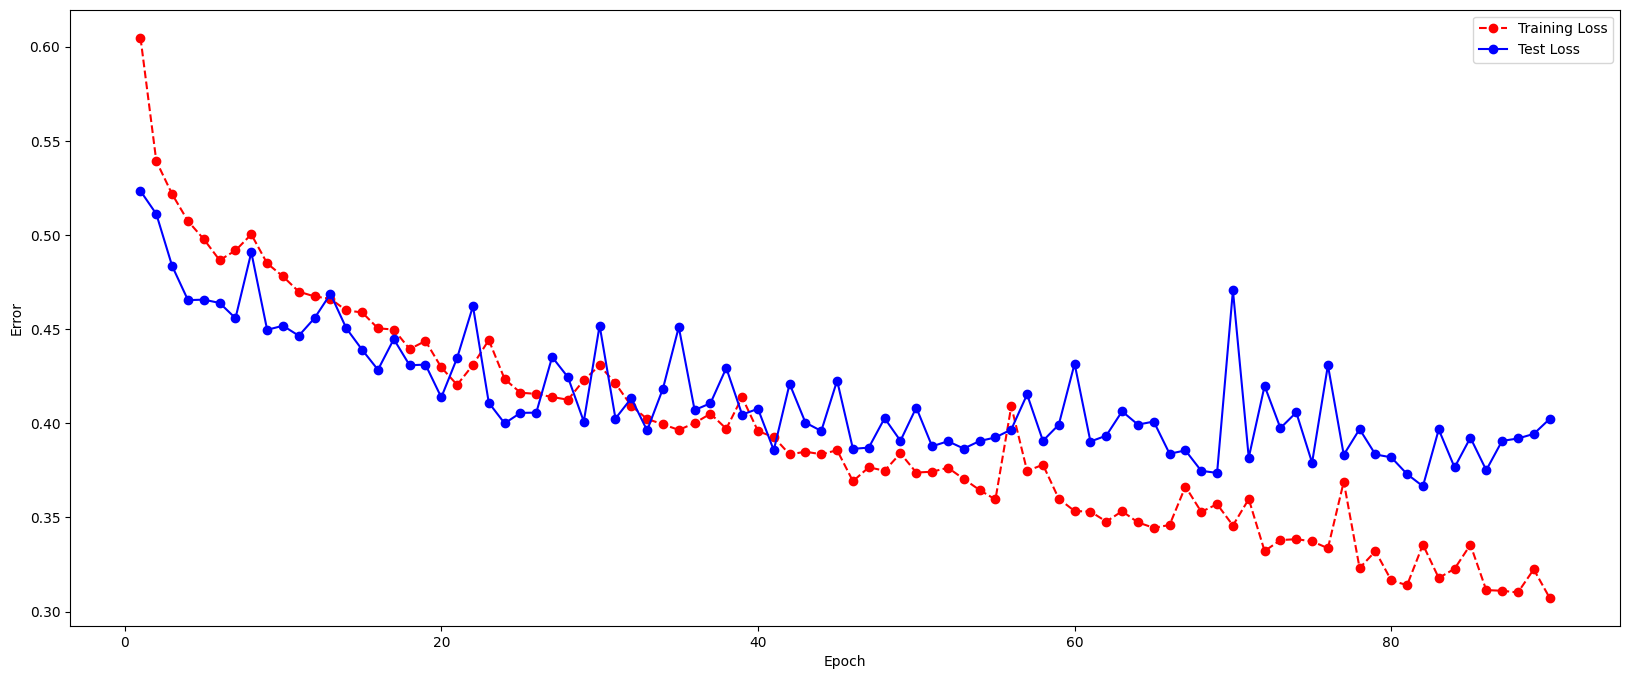

In [54]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [55]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.40225619077682495 val_accuracy: 0.8279430866241455
El algoritmo acerto 640 veces sobre los 773 casos.


In [77]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
